# SI: On the Molecular Anion-Cation Contrast of Caffeine Solvation in Salt Solutions.

Stefan Hervø-Hansen<sup>a</sup>, Mikael Lund<sup>a</sup>, and Nobuyuki Matubayasi<sup>b</sup><br><br>
<sup>a</sup> Division of Theoretical Chemistry, Department of Chemistry, Lund University, Lund SE 221 00, Sweden.<br> <sup>b</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
To whom correspondence may be addressed: stefan.hervo_hansen@teokem.lu.se, mikael.lund@teokem.lu.se, and nobuyuki@cheng.es.osaka-u.ac.jp.

# Part 2: Analysis

## Introduction

We present a study of the solvation free energy of caffeine in electrolyte solutions using the theoy of energy-representation in combination with all-atom simulations. In specific we desire to calculate Setschenow (Sechenov) coefficients, $k_s$,[<sup>1</sup>](#fn1) for various salts. The Setschenow equation[<sup>1</sup>](#fn1) is on the $\ln$-scale given as
$$ \ln \frac{S}{S_0} =  -k_sc_s = \ln\gamma = \frac{\Delta\mu^{ex}}{kT} \tag 1$$
where $S$ and $S_0$ are solubilities in pure water and an electrolyte solution of concentration $c_s$. In litterature eq. 1 is most commonly presented on $\log_{10}$ scale, however on the persented form, the Setschenow equation shows its clear relationship to the activity coefficient and chemical potential. In this notebook we will conduct all atomic molecular dynamics simulations.

### Methods & Materials
Molecular dynamics simulations are conducted using the openMM (7.4.0)[<sup>2</sup>](#fn2) software package modded with the openmmtools[<sup>3</sup>](#fn3) and parmed[<sup>4</sup>](#fn4) packages. For the simulation of caffeine a GROMOS (ffGF53a6) derived Kirkwood-Buff force field with adjustments to the partial charges and geometrical parameters, which has previously been able able to reproduce experimental solubilities of caffeine in water and urea solutions[<sup>5</sup>](#fn5) was employed with the SPC/E[<sup>6</sup>](#fn6) force field employed for water and optimized ion parameters for alkali cations and halide anions[<sup>7</sup>](#fn7). The isothermal-isobaric ensemble will be sampled using a combination of a geodesic Langevin integrator[<sup>8</sup>](#fn8) and a Monte Carlo barostat[<sup>9,</sup>](#fn9)[<sup>10</sup>](#fn10). To do the simulations see the [Part 1 Jupyter notebook](Simulations.ipynb). The trajectories will be analysed using MDtraj[<sup>11</sup>](#fn11) for structual properties, while ERmod[<sup>12</sup>](#fn12) be utilized for the calculation of solvation free energies


### References
1. <span id="fn1"> Setschenow J (1889) Über die Konstitution der Salzlösungen auf Grund ihres Verhaltens zu Kohlensäure. Zeitschrift für Physikalische Chemie 4U(1):117–125.
2. <span id="fn1"> Eastman P, et al. (2017) OpenMM 7: Rapid development of high performance algorithms for molecular dynamics. PLOS Computational Biology 13(7):e1005659.</span><br>
3. <span id="fn2"> https://github.com/choderalab/openmmtools</span><br>
4. <span id="fn3"> https://github.com/ParmEd/ParmEd </span><br>
5. <span id="fn4"> Sanjeewa R, Weerasinghe S (2010) Development of a molecular mechanics force field for caffeine to investigate the interactions of caffeine in different solvent media. Journal of Molecular Structure: THEOCHEM 944(1–3):116–123. </span><br>
6. <span id="fn5"> Berendsen HJC, Grigera JR, Straatsma TP (1987) The missing term in effective pair potentials. The Journal of Physical Chemistry 91(24):6269–6271. </span><br>
7. <span id="fn6"> Heyda J, Vincent JC, Tobias DJ, Dzubiella J, Jungwirth P (2010) Ion Specificity at the Peptide Bond: Molecular Dynamics Simulations of N-Methylacetamide in Aqueous Salt Solutions. The Journal of Physical Chemistry B 114(2):1213–1220. </span><br>
8. <span id="fn8"> Leimkuhler B, Matthews C (2016) Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 472(2189):20160138. </span><br>
9. <span id="fn9"> Chow K-H, Ferguson DM (1995) Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91(1–3):283–289. </span><br>
10. <span id="fn10"> Åqvist J, Wennerström P, Nervall M, Bjelic S, Brandsdal BO (2004) Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384(4–6):288–294. </span><br>
11. <span id="fn11"> McGibbon RT, et al. (2015) MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109(8):1528–1532. </span><br>
12. <span id="fn12"> Sakuraba S, Matubayasi N (2014) Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. Journal of Computational Chemistry 35(21):1592–1608. </span><br>

### Import of Python Modules & Definition of Auxiliary Functions

In [1]:
#Notebook dependent libs
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import mdtraj as md
import os, time, re, yaml, string
from scipy.stats import linregress

homedir='/home/stefan/Caffeine_solubility'
# homedir = !pwd
kcal_to_kT = 1.688 # Assuming 298.15 K

from Auxiliary import getAvgVolume, BootstrapLinearRegression

### Simulation settings

In [2]:
# State of simulations, (outFreq is steps per frame)
Nruns = 25
states = {                                                               
          'sol': {'Nsteps': 1000000,  'OutFreq': 50}, # 2 nanoseconds, 20000 frames      (x25 50 ns)
          'ref': {'Nsteps': 200000,  'OutFreq': 500} # 0.4 nanoseconds, 400 frames       (x25 10 ns)
         }

salts = {'NaCl' : {'Cation': 'Na', 'Anion': 'Cl' },
         'NaI'  : {'Cation': 'Na', 'Anion': 'I'  },
         'NaF'  : {'Cation': 'Na', 'Anion': 'F'  },
         'KCl'  : {'Cation': 'K' , 'Anion': 'Cl' },
         'KI'   : {'Cation': 'K' , 'Anion': 'I'  },
         'KF'   : {'Cation': 'K' , 'Anion': 'F'  },
         'CsCl' : {'Cation': 'Cs', 'Anion': 'Cl' },
         'CsI'  : {'Cation': 'Cs', 'Anion': 'I'  },
         'CsF'  : {'Cation': 'Cs', 'Anion': 'F'  } 
        }

# Approximate concentrations of salts with
salt_concentrations = {
#                        0.00: {'Caffeine': 1, 'Water': 1000, 'Cation':0,  'Anion':0},
#                       0.25: {'Caffeine': 1, 'Water': 1000, 'Cation':5,  'Anion':5},
                       0.50: {'Caffeine': 1, 'Water': 1000, 'Cation':9,  'Anion':9},
#                       0.75: {'Caffeine': 1, 'Water': 1000, 'Cation':14, 'Anion':14},
                       1.00: {'Caffeine': 1, 'Water': 1000, 'Cation':18, 'Anion':18},
#                       1.25: {'Caffeine': 1, 'Water': 1000, 'Cation':23, 'Anion':23},   
                       1.50: {'Caffeine': 1, 'Water': 1000, 'Cation':27, 'Anion':27},   
#                       1.75: {'Caffeine': 1, 'Water': 1000, 'Cation':32, 'Anion':32},
                       2.00: {'Caffeine': 1, 'Water': 1000, 'Cation':36, 'Anion':36}   
                      }

## Analysis
### Prepare ERmod analysis
<img style="float: right;width:319.5px;height:312.5px;" src="images/ermod.png" title="Simulation flow" >

The determination of solvation free energies and chemical potentials though the ERmod software is conducted in two stages as illustrated in the figure. First is the determination of the energy distribution functions from the simulation trajectories obtained from molecular dynamics using the subprogram `ermod`. Second is the solvation free energy is determined from the energy distribution functions though an approximate functional using the subprogram `slvfe`.

Documentation for the parameter file `parameters_er` which determines how the `ermod` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-ermod03/). In the python code below it can be noted many of the parameters has been given the keyword `[correct]`, these settings are dependent on the simulation settings and or the software being used and are thus recommended not to be changed if using the openMM setup above. The parameters given the keyword `[to be set]` are settings either collected from the output of the openMM script or set by the user, in specific the values for `maxins` and `engdiv` should be given by the user are given the default value of 1000 and 5 respectively.

Documentation for the parameter file `parameters_fe` which determines how the `slvfe` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-slvfe/). It is recommended not to change the parameters in this file with the exception of the temperature if conducting simulations at other temperatures than 298.15 Kelvin, and the volume. In the code below the average volume input is calculated as an average volume from the two ensemble volume averages.

In [ ]:
# ERmod settings
Ninserts = 5000   # Number of inserts in the reference state (lambda=0)
ermod_script = """
&ene_param
      slttype = {state},     ! Choose system; 1: Solution system  2,3: Reference                     [to be set]
      boxshp = 1,            ! Boxtype                                                               [correct]   
      estype = 2,            ! Ensemble; 1: NVT   2: NPT                                             [correct]   
      inptemp = 298.15,      ! Temperature (in Kelvin)                                               [correct]   
      ljformat = 2,          ! LJ form                                                               [correct]   
      cmbrule = 1,           ! Combination rule                                                      [correct]   
      ljswitch = 1,          ! Switching function for smooth LJ truncation                           [correct]   
      upljcut = 12,          ! Upper limit for LJ cutoff switching function (in Angstrom)            [correct]   
      lwljcut = 10,          ! Lower limit for LJ cutoff switching function (in Angstrom)            [correct]   
      cltype = 2,            ! Treatment of Coulomb interaction (2=PME)                              [correct]   
      elecut = 12.0,         ! Cutoff of the real-space electrostatic interaction (in angstrom)      [correct]   
      ewtoler = 0.00001,     ! Error tolerance in Ewald                                              [correct]   
      splodr = 5,            ! Order of spline function used in PME                                  [correct]   
      ms1max = {PMEnodes_x}, ! Number of meshes in PME (x)                                           [to be set] 
      ms2max = {PMEnodes_y}, ! Number of meshes in PME (y)                                           [to be set] 
      ms3max = {PMEnodes_z}, ! Number of meshes in PME (z)                                           [to be set] 
{ref} maxins = {Ninserts},   ! Number of inserts (chosen freely, for reference ONLY)                 [to be set] 
      engdiv = {Ndivisions}, ! Number of divisions of the total simulation length (chosen freely)    [to be set] 
/
&hist
      eclbin=5.0e-2, ecfbin=2.0e-3, ec0bin=2.0e-4, finfac=10.0e0,
      ecdmin=-45.000000, ecfmns=-0.20e0, ecdcen=0.0e0, eccore=30.0e0,
      ecdmax=1.0e11, pecore=200
/
"""
    
slvfe_script = """
&fevars
clcond    = "merge",       ! Calculation type, "merge" / "basic" / "range"
numsln    = {Nsol_blocks}, ! Number of trajectory blocks in solution system
numref    = {Nref_blocks}, ! Number of trajectory blocks in reference system
numdiv    = {Nsol_blocks}, ! Number of division for statistics, usually set equal to numsln
avevolume = {avgV},        ! Average volume sampled in simulation (in Angstrom^3)

ljlrc     = 'yes',         ! Long-range correction of the Lennard-Jones interaction (avevolume must be specified)
uvread    = "yes",         ! "not" if average solute-solvent energy is calculated from engsln, instead of aveuv.tt
slfslt    = "yes",         ! "not" if the solute self energy is not read
infchk    = "yes",         ! Enable error analysis for the logarithmic-mesh part
inptemp   = 298.15,        ! Input Temperature in Kelvin
cumuint   = 'yes',         ! Enable running integral calculations.
/
"""

### Generate ERmod Files
The following cell is fairly complicated and uses a mix of bash and python. While ERmod provides tools to assist in the construction of input files based on many popular molecular dynamics packages log files openMM is still yet to be supported. In the following we manually create the files. The steps are as follow:
1. Use the ERmod's `gen_structure` script to generate non-compleate input scripts as well as the folers `refs` and `soln` containing pair-energy distrubtions at $\lambda=0$ and $\lambda=1$ respectively.
2. For soln and refs: Construct a `parameter_er` file as previously described, with updated PME parameters.
3. For soln and refs: Edit the MDinfo file containing the number of frames in the solution and reference state.
4. For soln and refs: Create a symlink named `HISTORY` linking to the joint trajectory for the solution and reference state.
5. For refs: Create a symlink named `SltConf` linking to the vacuum trajectory of caffeine.
6. Create the `parameters_fe` file with the main edit being the average volume sampled at $\lambda=1$ for long-range correction of Lennard-Jones interactions.

In [ ]:
%cd -q $homedir
for saltdir, salt in salts.items():
    for concentration in salt_concentrations:
        conc = '{0:.2f}'.format(concentration)
        %cd -q $homedir/Simulations/$saltdir/$conc
        topfile = 'Caffeine_{}_sol.top'.format(saltdir)
        !echo 2S09 | /usr/bin/python ~/software/ermod-0.3.6_openMM/share/ermod/tools/gromacs/gen_structure --top $topfile
        
        #!# Solution settings #!#
        %cd -q $homedir/Simulations/$saltdir/$conc/soln
        
        ###### WRITING ERMOD PARAMETER FILE ######
        # PME settings
        with open('../0/run_sol.out', 'r') as logfile:
            lines = logfile.readlines()
            logfile.close()
        index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
        PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
        N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]), *re.findall("([0-9]+)", lines[index+3]), *re.findall("([0-9]+)", lines[index+4]))
        
        comment = '!'
        stateID = 1
        
        with open('parameters_er', 'w') as text_file:
            text_file.write(ermod_script.format(state=stateID, Ninserts=Ninserts, Ndivisions=25, PMEnodes_x=N_gridpoints[0],
                                                PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2], ref=comment))
        
        ####### CORRECTING MDinfo FILE #########
        with open('MDinfo', 'r') as f:
            lines = f.readlines()
            f.close()
            
        with open('MDinfo', 'w') as f:
            lines[0] = lines[0].replace('FRAMES', '500000')
            for line in lines:
                f.write(line)
            f.close()
        
        ####### CREATING HISTORY SYMLINK #########
        !ln -s $homedir/Simulations/$saltdir/$conc/trajectory_sol_full.xtc HISTORY
        
        #!# Reference settings #!#
        %cd -q $homedir/Simulations/$saltdir/$conc/refs
        
        ###### WRITING ERMOD PARAMETER FILE ######
        # PME settings
        with open('../0/run_ref.out', 'r') as logfile:
            lines = logfile.readlines()
            logfile.close()
        index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
        PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
        N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]), *re.findall("([0-9]+)", lines[index+3]), *re.findall("([0-9]+)", lines[index+4]))
        
        comment = '  '
        stateID = 3     # 3=flexible, 1=fixed
        
        with open('parameters_er', 'w') as text_file:
            text_file.write(ermod_script.format(state=stateID, Ninserts=Ninserts, Ndivisions=10, PMEnodes_x=N_gridpoints[0],
                                                PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2], ref=comment))
        
        ####### CORRECTING MDinfo FILE #########
        with open('MDinfo', 'r') as f:
            lines = f.readlines()
            f.close()
            
        with open('MDinfo', 'w') as f:
            lines[0] = lines[0].replace('FRAMES', '10000')
            for line in lines:
                f.write(line)
            f.close()
        
        ####### CREATING HISTORY AND SltConf SYMLINK #########
        !ln -s $homedir/Simulations/$saltdir/$conc/trajectory_ref_full.xtc HISTORY
        !ln -s $homedir/Simulations/Solute/trajectory_solute.xtc SltConf
    
        
        #! FREE ENERGY CALCULATION !#
        %cd -q $homedir/Simulations/$saltdir/$conc
        # calculate avg volume from the two ensemble averages
        avgVolume = getAvgVolume('output_ref.dat', Nruns=25, volcolumn=4, returning='float')
        
        # Make parameter file
        with open('parameters_fe', 'w') as text_file:
            text_file.write(slvfe_script.format(Nsol_blocks=25, Nref_blocks=10, avgV=avgVolume))
            
        print('Wrote ERmod analysis files to '+os.getcwd())

### Submit ERmod analysis
Submit script for servers employing job scheduling. The below example is utilizing PBS (for a quick guide see [here](https://latisresearch.umn.edu/creating-a-PBS-script)). However the code below may be edited to utilize Slurm instead (documentation [here](https://slurm.schedmd.com)) by changing the variable `submit_script` and by executing the commands `!sbatch submit_ermod.pbs` instead of `qsub`.

In [ ]:
submit_script="""#!/bin/bash
#PBS -l nodes=1:ppn=36:cpu            # 1 node, 36 cores, CPU nodes
#PBS -N ermod_{conc}_{salt}              # Name of job
#PBS -e ermod.err                     # error output
#PBS -o ermod.out                     # output file name

source ~/.bashrc
source ~/.bash_profile
export ERMOD=/home/stefan/software/ermod-0.3.7
export ERMOD_PLUGINS=/home/stefan/software/ermod-0.3.7libexec/ermod
PATH=$PATH:/home/stefan/software/ermod-0.3.7/bin
export PATH

cd {path}

# Solution step
cd soln
mpirun -np 36 ermod
cd ..

# Reference step
cd refs
mpirun -np 36 ermod
cd ..

# Calculate solvation energy
slvfe
"""


%cd -q $homedir
for saltdir, salt in salts.items():
    for i, concentration in enumerate(salt_concentrations):
        conc = '{0:.2f}'.format(concentration)
        %cd -q $homedir/Simulations/$saltdir/$conc
        
        with open('submit_ermod.pbs', 'w') as text_file:
                text_file.write(submit_script.format(path=os.getcwd(), conc=conc, salt=saltdir))
        !qsub submit_ermod.pbs
        time.sleep(1)

## Solvation free energies: The First Loook
The results from the ERmod analysis have been stored in a easier readable format in the file `_results.yml` containing the solvation free energy of caffeine in different salt solutions and salt concentrations. The solvation free energy within the framework of energy-representation theory of solvation can be written as (eq. 5 in the original paper)
\begin{equation}
    \Delta G_{\mathrm{sol}} = \Delta G_{\mathrm{self}} + \Delta G_{\mathrm{anion}} + \Delta G_{\mathrm{cation}} + \Delta G_{\mathrm{water}},
    \label{eq:SolventDecomposition}
\end{equation}
where the individual terms constitute the chemical species contribution to the solvation free energy of caffeine. The contribution from the anions, cations and water for the various salt solutions and concentrations can also be found in the file `_results.yml`.

In the following code, we will first inspect the self-energy, being the first term of the previous equation. Next the solvation free energy's variation with salt concentration for the different salt solutions will be visualized together with the decomposition. The code is utilizing the raw output files given by ERmod, ralther than the .yml files.

### Caffeine self-energy

In [3]:
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.50, 1.00, 1.50, 2.00] # Folder structure.

self = []

# Water
with open('Simulations/Nosalt/slvfe.out') as f:
    lines = f.readlines()
f.close()
for line in lines:
    if "Self-energy of the solute" in line:
        self.append(float(line.split()[5]))

# Salt and concentration loop
for salt in salts:
    for conc in concs:
        with open('Simulations/{salt}/{conc:.2f}/slvfe.out'.format(salt=salt, conc=conc)) as f:
            lines = f.readlines()
        f.close()
        for line in lines:
            if "Self-energy of the solute" in line:
                self.append(float(line.split()[5]))
                
self = np.asarray(self)
print('Mean self contribution ranges from {:.3} to {:.3} kcal/mol.'
      .format(self.flatten().min(), self.flatten().max()))

Mean self contribution ranges from -0.0169 to -0.0146 kcal/mol.


### Solvation free energy variation with salt and decomposition
In the following code we will now compute the Setschenow coefficient from the free energy of solvation for the chemical species. To obtain the error we utilize non-parametric bootstrapping, being the slowest element of the code and may be varried to speed up the computation.

_<b>Warning</b>: Slow computation cell. Vary the input to the `BootstrapLinearRegression` function to decrease the computation time._

In [4]:
files = ['_results.yml', '_results_Ksalts.yml', '_results_Cssalts.yml'] # Sodium, Kalium, Caesium
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.00, 0.50, 1.00, 1.50, 2.00] # Folder structure.

SetCof = np.empty(shape=(len(salts), 4))
SetCofErr = np.empty(shape=(len(salts), 4))

for convar, salt in enumerate(salts):
    mu = []
    mu_error = []
    
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                concentrations = data['conc']
                color = data['color']
                label = data['label']
                break
    
    for specie in [1,3,5,7]:
        chempots = np.zeros(shape=(25, 5))
        for i, conc in enumerate(concs):
            if conc == 0 and (specie == 3 or specie ==5):
                continue
            elif conc == 0:
                with open('/home/stefan/Caffeine_solubility/Simulations/Nosalt/slvfe.out') as f:
                    numlines = len(f.readlines())
                f.close()
                data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/Nosalt/slvfe.out', skiprows=numlines-25, usecols=(1))
            else:
                with open('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/slvfe.out'.format(salt=salt, conc=conc)) as f:
                    numlines = len(f.readlines())
                f.close()
                data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/slvfe.out'.format(salt=salt, conc=conc),
                                  skiprows=numlines-25, usecols=(specie))
            temp = []
            for point in reversed(range(len(data))):
                temp.append((point+1) * data[point] - (point) * data[point-1])
            chempots[:,i] = np.array(temp)
        
        popt = BootstrapLinearRegression(concentrations, chempots)
        mu.append(popt[0][0]*kcal_to_kT)
        mu_error.append(popt[0][1]*kcal_to_kT)
    
    SetCof[convar] = np.array(mu)
    SetCofErr[convar] = np.array(mu_error)

With the following visualization of the data

Setschenow coefficient (NaF) = 1.046505611892971
Setschenow coefficient (NaCl) = 0.6675338163693324
Setschenow coefficient (NaI) = 0.12060493579589976
Setschenow coefficient (KF) = 1.0439742139968438
Setschenow coefficient (KCl) = 0.498577862401858
Setschenow coefficient (KI) = -0.033160299821860695
Setschenow coefficient (CsF) = 0.9636150921574876
Setschenow coefficient (CsCl) = 0.3950409437966217
Setschenow coefficient (CsI) = -0.09204385392400107


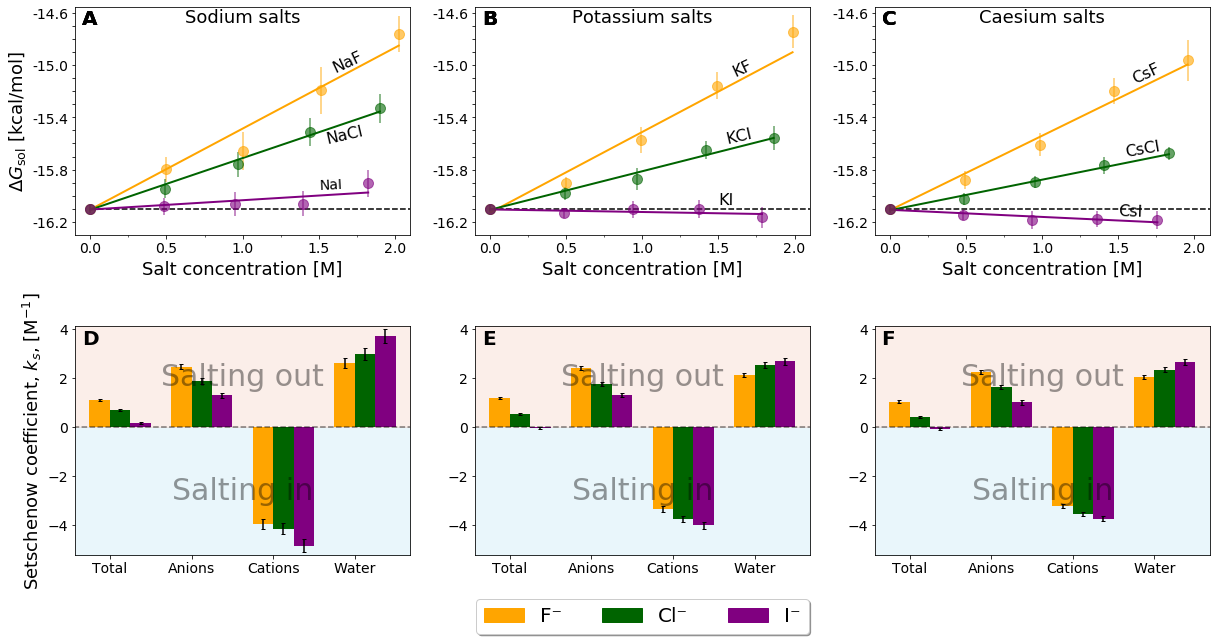

In [5]:
fig, axes = plt.subplots(2,3)
fig.set_size_inches(17,4.5*2)

files = ['_results.yml', '_results_Ksalts.yml', '_results_Cssalts.yml'] # Sodium, Kalium, Caesium
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.00, 0.50, 1.00, 1.50, 2.00] # Folder structure.


## UPPER PLOT

# Water
with open('/home/stefan/Caffeine_solubility/Simulations/Nosalt/slvfe.out') as f:
    mu_wat = f.readlines()[-1].split()[1:]
f.close

for index, salt in enumerate(salts):
    mu = np.empty(shape=(2, 5))
    mu[0,0] = mu_wat[0]
    mu[1,0] = mu_wat[1]
    for i, conc in enumerate(concs[1:]):
        with open('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/slvfe.out'.format(salt=salt, conc=conc)) as f:
            slvfe = f.readlines()[-1].split()[1:]
        f.close()
        mu[0,i+1] = slvfe[0]
        mu[1,i+1] = slvfe[1]
        
        
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                concentrations = data['conc']
                color = data['color']
                label = data['label']
                break
    fit    = np.polyfit(concentrations, mu[0], 1, w=1/mu[1])
    fit_fn = np.poly1d(fit)
    print("Setschenow coefficient ("+salt+") =", fit[0]*kcal_to_kT)
    axes[0][int(index/3)].errorbar(concentrations, mu[0], yerr=mu[1],
                        fmt='o', c=color, alpha=0.6, ms=10)
    axes[0][int(index/3)].plot(concentrations, fit_fn(concentrations), label=label, c=color, lw=2, ms=10)
    
    axes[0][int(index/3)].set_xlim(-0.1, 2.1)
    axes[0][int(index/3)].set_ylim(-16.3, -14.55)
    axes[0][int(index/3)].set_xlabel('Salt concentration [M]', fontsize=18)
    axes[0][0].set_ylabel('$\Delta G_{\mathrm{sol}}$ [kcal/mol]', fontsize=18)
    axes[0][int(index/3)].text(0.02, 0.92, string.ascii_uppercase[int(index/3)], transform=axes[0][int(index/3)].transAxes, 
                               size=20, weight='bold')
    axes[0][int(index/3)].hlines(-16.10 ,0, 2.5, color='black', alpha=0.5, linestyle='dashed')
    axes[0][int(index/3)].xaxis.set_major_locator(MultipleLocator(0.5))
    axes[0][int(index/3)].xaxis.set_minor_locator(MultipleLocator(0.25))
    axes[0][int(index/3)].tick_params(axis='both', labelsize=14)
    axes[0][int(index/3)].set_xticks([0, 0.5, 1.0, 1.5, 2.0])
    axes[0][int(index/3)].set_yticks(np.arange(-16.2, -14.6+0.1, 0.1))
    
    ylabels = np.arange(-16.2, -14.6+0.1, 0.1)
    ylabels = ylabels.tolist()
    for enu,value in enumerate(ylabels):
        if np.mod(enu, 4) == 0:
            ylabels[enu] = str(round(value, ndigits=1))
        else:
            ylabels[enu] = ' '
    axes[0][int(index/3)].set_yticklabels(ylabels)

axes[0][0].text(1.5, -15.95, 'NaI', rotation=3, fontsize=14)
axes[0][0].text(1.54, -15.6, 'NaCl', rotation=13, fontsize=16)
axes[0][0].text(1.58, -15.05, 'NaF', rotation=25, fontsize=16)
axes[0][1].text(1.5, -16.07, 'KI', rotation=-0.5, fontsize=16)
axes[0][1].text(1.54, -15.6, 'KCl', rotation=13, fontsize=16)
axes[0][1].text(1.58, -15.08, 'KF', rotation=25, fontsize=16)
axes[0][2].text(1.5, -16.16, 'CsI', rotation=-2, fontsize=16)
axes[0][2].text(1.54, -15.7, 'CsCl', rotation=10, fontsize=16)
axes[0][2].text(1.58, -15.14, 'CsF', rotation=25, fontsize=16)


## LOWER PLOT 
index = np.arange(4)
width = 0.25
offset = 0
ctrl = 0; j = 0

for convar, salt in enumerate(salts):
    if ctrl == 3:
        offset = 0
        ctrl = 0; j += 1

    ctrl += 1
    
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                color = data['color']
                label = data['label']
                break
    
    axes[1][j].bar(index+offset, SetCof[convar], width=width, alpha=1.0, yerr=SetCofErr[convar], capsize=2,
                color=color, label=label)
    offset += width
    
        
for i,ax in enumerate(axes[1]):
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(('Total', 'Anions', 'Cations', 'Water'))
    axes[1][0].set_ylabel('Setschenow coefficient, $k_s$, [M$^{-1}$]', fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(-5.2, 4.1)
    ax.set_xlim(-0.3, 3.8)
    axes[1][i].text(0.02, 0.92, string.ascii_uppercase[i+3], transform=axes[1][i].transAxes, 
                    size=20, weight='bold')
    axes[1][i].hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed')
    axes[1][i].fill_between(np.arange(-5, 5, 0.1), [-5.2 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                            color='#c9e9f6', alpha=0.4)
    axes[1][i].fill_between(np.arange(-5, 5, 0.1), [4.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                            color='#f6d6c9', alpha=0.4)
    axes[1][i].text(1.75, -2.6, 'Salting in', horizontalalignment='center', verticalalignment='center',
                    fontsize=30, alpha=0.4, zorder=10)
    axes[1][i].text(1.75, 2.05, 'Salting out', horizontalalignment='center', verticalalignment='center',
                    fontsize=30, alpha=0.4, zorder=10)
    
    
################
# AD HOC FIXES #
################
axes[0][0].set_title('Sodium salts', pad=-16, y=1.001, fontsize=18)
axes[0][1].set_title('Potassium salts', pad=-16, y=1.001, fontsize=18)
axes[0][2].set_title('Caesium salts', pad=-16, y=1.001, fontsize=18)
handles = [mpatches.Patch(color='orange', label='F⁻'),
           mpatches.Patch(color='darkgreen', label='Cl⁻'),
           mpatches.Patch(color='purple', label='I⁻')]
axes[1][1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, shadow=True, ncol=5, fontsize=18, prop={'size': 20})

fig.tight_layout()
fig.savefig('images/SetschenowCombined.pdf', bbox_inches='tight')
fig.show()

### Overview of the individual contributions for the various salts and concentrations 

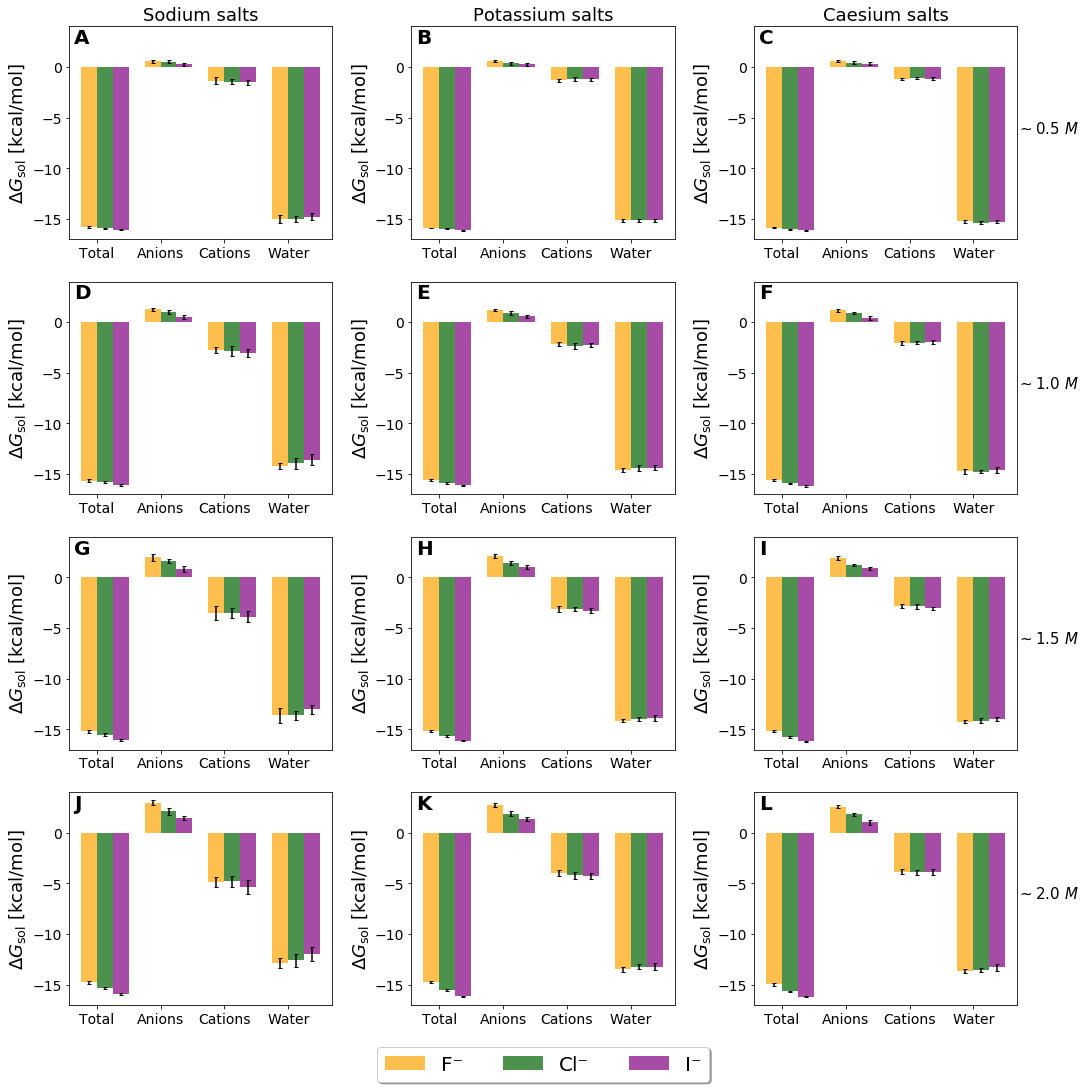

In [6]:
%cd -q $homedir

files = ['_results.yml', '_results_Ksalts.yml', '_results_Cssalts.yml'] # Sodium, Kalium, Caesium
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.50, 1.00, 1.50, 2.00] # Folder structure.

fig, axes = plt.subplots(4,3)
fig.set_size_inches(17,4.5*4)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


for i, conc in enumerate(concs):
    # Histogram settings
    width=0.25
    offset=0
    index = np.arange(4)
    
    for j, salt in enumerate(salts):
        if int(j%3) == 0:
            offset = 0
        mu = np.empty(shape=(2,4))
        with open('Simulations/{salt}/{conc:.2f}/slvfe.out'.format(salt=salt, conc=conc)) as f:
            slvfe = f.readlines()[-1].split()[1:]
        mu[0] = slvfe[0::2]
        mu[1] = slvfe[1::2]
        
        for file in files: # Loop over cations
            with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
                r = yaml.load(f, Loader=yaml.Loader)
            for data in r['salts']:
                if (data['label'] == salt):
                    color = data['color']
                    label = data['label']
                    break
        axes[i][int(j/3)].bar(index+offset, mu[0], yerr=mu[1], color=color, label=label,
                              width=width, alpha=0.7, capsize=2)
        offset += width
        
for i,ax in enumerate(axes.flatten()):
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(('Total', 'Anions', 'Cations', 'Water'), fontsize='large')
    ax.set_ylabel('$\Delta G_{\mathrm{sol}}$ [kcal/mol]', fontsize=18)
    ax.set_ylim(-17.0, 4.0)
    ax.text(0.02, 0.92, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
    ax.tick_params(axis='both', labelsize=14)

labels = ['F⁻', 'Cl⁻', 'I⁻']
axes[0][0].set_title('Sodium salts', fontsize=18)
axes[0][1].set_title('Potassium salts', fontsize=18)
axes[0][2].set_title('Caesium salts', fontsize=18)
axes[3][1].legend(labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, fontsize=18, prop={'size': 20})
axes[0][2].text(1.0, 0.5, '$\sim 0.5 \ M$', transform=axes[0][2].transAxes, size=15)
axes[0][2].text(1.0, 0.5, '$\sim 1.0 \ M$', transform=axes[1][2].transAxes, size=15)
axes[0][2].text(1.0, 0.5, '$\sim 1.5 \ M$', transform=axes[2][2].transAxes, size=15)
axes[0][2].text(1.0, 0.5, '$\sim 2.0 \ M$', transform=axes[3][2].transAxes, size=15)


fig.savefig('images/SolvationMultiplot.pdf', bbox_inches='tight')
fig.show()

## Excluded volume contribution
The individual species contribution to the chemical potential within the energy-representation theory of solvation is given by
\begin{equation}
    \Delta G_i = \langle \nu \rangle_i - \int f(\varepsilon_i) \ \mathrm{d}\varepsilon_i
\end{equation}
where the first term is the average pair-energy at $\lambda=1$ and the second term is the integration over a functional depending on the pair-energy distribution at $\lambda=0$ and $\lambda=1$. We choose to defined the excluded volume energy regime as all energies higher than the maximum pair-energy observed at $\lambda=1$. Integration over the energy coordinate in this regime reduces the above equation to
\begin{equation}
    \Delta G_i^{\mathrm{EV}} = \int_{\varepsilon_{\mathrm{max}}}^{\infty} f(\varepsilon_i) \ \mathrm{d}\varepsilon_i
\end{equation}
In the code below we will first visualize the cummulative solvation free energy as a function the energy coordinate for caffeine in ~2.00 M CsCl salt solution, to get familar with relationship between the energy coordinate the solvation free energy.

In [7]:
# Determine epsilon_max
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.50, 1.00, 1.50, 2.00] # Folder structure.

emax_list = []

# Water
max_pair_energy = np.loadtxt('Simulations/Nosalt/soln/uvrange.tt', usecols=2, skiprows=1)
emax_list.append(max(max_pair_energy))

# Salt and concentration loop
for salt in salts:
    for conc in concs:
        max_pair_energy = np.loadtxt('Simulations/{salt}/{conc:.2f}/soln/uvrange.tt'.format(salt=salt, conc=conc),
        usecols=2, skiprows=1)
        emax_list.append(max(max_pair_energy))
                
emax_list = np.asarray(emax_list)
print('Maximum pair-energy at λ=1 ranges from {:.3} to {:.3} kcal/mol.'
      .format(emax_list.flatten().min(), emax_list.flatten().max()))

emax = emax_list.flatten().max()

Maximum pair-energy at λ=1 ranges from 8.76 to 21.2 kcal/mol.


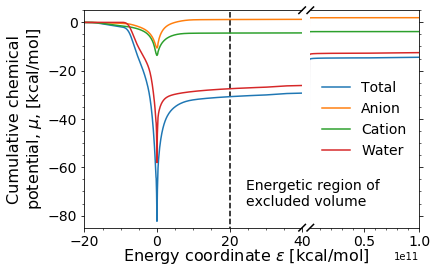

In [8]:
data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/CsCl/2.00/cumsfe', usecols=(0,1,2,3,4))

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True, facecolor='w', gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(wspace=0.05, hspace=None)

for ax in (ax1, ax2):
    ax.plot(data[:,0], data[:,1], label='Total')
    ax.plot(data[:,0], data[:,2], label='Anion')
    ax.plot(data[:,0], data[:,3], label='Cation')
    ax.plot(data[:,0], data[:,4], label='Water')

ax1.vlines(20, -100, 20, linestyle='dashed')

ax1.set_xlim(-20, 40)
ax2.set_xlim(1e9,max(data[:,0]))
ax1.set_ylim(-85, 5)
ax2.set_ylim(-85, 5)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d*2,+d*2), (1-d,1+d), **kwargs) # Adjust based on width_ratios in the x axis.
ax2.plot((-d*2,+d*2), (-d,+d), **kwargs)   # Also here.

ax1.minorticks_on()
ax2.minorticks_on()
ax2.legend(loc=5, fontsize=14, frameon=False)

fig.text(0.5, 0.2 ,f'Energetic region of \nexcluded volume', fontsize=14)
fig.text(0.5, 0.01, r'Energy coordinate $\epsilon$ [kcal/mol]', fontsize=16, ha='center')
ax1.set_ylabel(f'Cumulative chemical\npotential'+ r', $\mu$, [kcal/mol]', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

fig.savefig('images/CsCl_2.00M_CumChemPot.pdf', bbox_inches='tight')

In the following code we will now compute the Setschenow coefficient using the excluded volume component of the free energy of solvation for the chemical species. To obtain the error we ones more utilize non-parametric bootstrapping, being the slowest element of the code and may be varried to speed up the computation.

_<b>Warning</b>: Slow computation cell. VaryVarry the input to the `BootstrapLinearRegression` function to decrease the computation time._

In [9]:
files = ['_results.yml', '_results_Ksalts.yml', '_results_Cssalts.yml'] # Sodium, Kalium, Caesium
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.00, 0.50, 1.00, 1.50, 2.00]

SetCof_eV  = np.empty(shape=(len(salts), 4))
SetCofErr_eV = np.empty(shape=(len(salts), 4))

for convar, salt in enumerate(salts):
    mu = []
    mu_error = []
    
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                concentrations = data['conc']
                break
    
    for specie in range(1,5):
        chempots = np.zeros(shape=(25, 5))
        for i, conc in enumerate(concs):
            if conc == 0 and (specie == 2 or specie ==3):
                chempots[:,0] = np.zeros(shape=(25))
            elif conc == 0:
                for fileNr in range(1,26):
                    data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/Nosalt/cumsfe{fileNr:02d}'.format(fileNr=fileNr),
                                      usecols=(0,1))
                    chempots[fileNr-1,0] = data[-1, 1] - np.interp(20, data[:,0], data[:,1])
            else:
                for fileNr in range(1,26):
                    data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/cumsfe{fileNr:02d}'.format(salt=salt, conc=conc, fileNr=fileNr),
                                      usecols=(0, specie))
                    chempots[fileNr-1,i] = data[-1, 1] - np.interp(20, data[:,0], data[:,1])
                    
        popt = BootstrapLinearRegression(concentrations, chempots)
        mu.append(popt[0][0]*kcal_to_kT)
        mu_error.append(popt[0][1]*kcal_to_kT)

    SetCof_eV[convar] = np.array(mu)
    SetCofErr_eV[convar] = np.array(mu_error)

### Linear correlation between excluded volume Setschenow coefficient and Setschenow coefficient.

r² value: 0.9851981538759064
p-value:  1.1549235142758847e-07


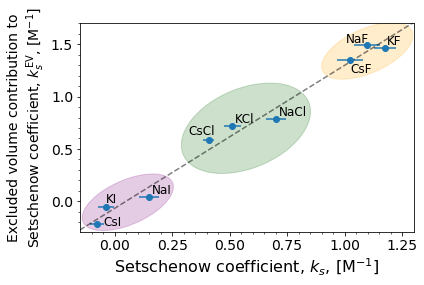

In [10]:
stats = linregress(SetCof[:,0], SetCof_eV[:,0])
print('r² value: {}'.format(stats.rvalue**2))
print('p-value:  {}'.format(stats.pvalue))

colors = ['orange', 'darkgreen', 'purple']
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.errorbar(SetCof[:,0], SetCof_eV[:,0], xerr=SetCofErr[:,0], yerr=SetCofErr_eV[:,0], marker='o', linestyle='None')
for i, txt in enumerate(salts):
    if txt == 'NaF':
        ax.annotate(txt, (SetCof[:,0][i]-0.09, SetCof_eV[:,0][i]+0.02), fontsize=12)
    elif txt =='KI':
        ax.annotate(txt, (SetCof[:,0][i], SetCof_eV[:,0][i]+0.05), fontsize=12)
    elif txt =='CsCl':
        ax.annotate(txt, (SetCof[:,0][i]-0.09, SetCof_eV[:,0][i]+0.05), fontsize=12)
    elif txt =='CsF':
        ax.annotate(txt, (SetCof[:,0][i], SetCof_eV[:,0][i]-0.12), fontsize=12)
    elif txt =='CsI':
        ax.annotate(txt, (SetCof[:,0][i]+0.03, SetCof_eV[:,0][i]-0.01), fontsize=12)
    else:
        ax.annotate(txt, (SetCof[:,0][i]+0.01, SetCof_eV[:,0][i]+0.03), fontsize=12)
ax.plot(np.arange(-0.2, 1.4, 0.001), np.arange(-0.2, 1.4, 0.001)*stats.slope + stats.intercept,
        alpha=0.5, color='black', linestyle='dashed')

for anion in range(3): # loop over anion species
    x = SetCof[:,0][anion:-1:3].mean()
    y = SetCof_eV[:,0][anion:-1:3].mean()
    if anion == 1:
        el = mpatches.Ellipse((x+0.03, y), 0.5, 0.9, angle=-20, alpha=0.2, color=colors[anion])
    else:
        el = mpatches.Ellipse((x, y), 0.3, 0.6, angle=-30, alpha=0.2, color=colors[anion])
    ax.add_artist(el)
    
ax.minorticks_on()
ax.set_ylabel(f'Excluded volume contribution to\nSetschenow coefficient, $k_{{s}}^{{\mathrm{{EV}}}}$, [M$^{{-1}}$]', fontsize=14)
ax.set_xlabel(r'Setschenow coefficient, $k_s$, [M$^{-1}$]', fontsize=16)
ax.set_xlim(-0.15, 1.3)
ax.set_ylim(-0.29, 1.7)
ax.tick_params(axis='both', labelsize=14)

fig.tight_layout()
fig.savefig('images/ExcludedVolumeCorrelation.pdf', bbox_inches='tight')

### Correlation species decompositon

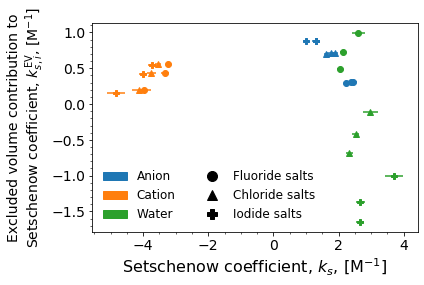

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

colors = ['C0', 'C1', 'C2']
labels = ['Anion', 'Cation', 'Water']
markers = ['o', '^', 'P']
for specie in range(1,4):
    for salt in range(len(salts)):
        color  = colors[specie-1]
        marker = markers[salt%3]
        ax.errorbar(SetCof[salt,specie], SetCof_eV[salt,specie], xerr=SetCofErr[salt,specie], yerr=SetCofErr_eV[salt,specie],
                color=color, marker=marker, linestyle='None')

handles = [mpatches.Patch(color='C0', label='Anion'), mpatches.Patch(color='C1', label='Cation'),
           mpatches.Patch(color='C2', label='Water'),
           mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Fluoride salts'),
           mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='Chloride salts'),
           mlines.Line2D([], [], color='black', marker='P', linestyle='None', markersize=10, label='Iodide salts')]
ax.legend(loc=0, handles=handles, frameon=False, ncol=2, prop={'size': 12})
ax.tick_params(axis='both', labelsize=14)


# Beautification
ax.minorticks_on()
ax.set_ylabel(f'Excluded volume contribution to\nSetschenow coefficient, $k_{{s,i}}^{{\mathrm{{EV}}}}$, [M$^{{-1}}$]', fontsize=14)
ax.set_xlabel(r'Setschenow coefficient, $k_s$, [M$^{-1}$]', fontsize=16)
fig.tight_layout()
fig.savefig('images/ExcludedVolumeCorrelationDecomposition.pdf', bbox_inches='tight')

### Linear correlation between excluded volume Setschenow coefficient and particle size

r² value: 0.9883706820646473


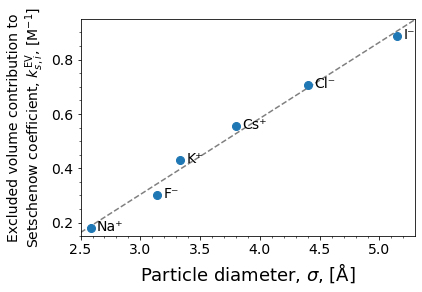

In [12]:
Species = ['Na⁺', 'K⁺', 'Cs⁺', 'F⁻', 'Cl⁻','I⁻']
sigma = np.array([0.2586, 0.3334, 0.38, 0.3143, 0.4401, 0.5149])*10

salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']

IonMeans = [SetCof_eV[0:3,2].mean(),  # Na
            SetCof_eV[3:6,2].mean(),  # K
            SetCof_eV[6:10,2].mean(), # Cs
            SetCof_eV[0::3,1].mean(), # I
            SetCof_eV[1::3,1].mean(), # Cl
            SetCof_eV[2::3,1].mean()] # F

IonStds  = [SetCof_eV[0:3,2].std(),  # Na
            SetCof_eV[3:6,2].std(),  # K
            SetCof_eV[6:10,2].std(), # Cs
            SetCof_eV[0::3,1].std(), # I
            SetCof_eV[1::3,1].std(), # Cl
            SetCof_eV[2::3,1].std()] # F

stats = linregress(sigma, IonMeans)
print('r² value: {}'.format(stats.rvalue**2))

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(sigma, IonMeans, IonStds, marker='o', linestyle='None', markersize=8)
ax.plot(np.arange(2.0, 6.0, 0.001), np.arange(2.0, 6.0, 0.001)*stats.slope + stats.intercept,
        alpha=0.5, color='black', linestyle='dashed')

for i, txt in enumerate(Species):
    ax.annotate(txt, (sigma[i]+0.05, IonMeans[i]-0.01), fontsize=14)
    
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel(f'Excluded volume contribution to\nSetschenow coefficient, $k_{{s,i}}^{{\mathrm{{EV}}}}$, [M$^{{-1}}$]', fontsize=14)
ax.set_xlabel(r'Particle diameter, $\sigma$, [Å]', fontsize=18)
ax.set_xlim(2.5, 5.3)
ax.set_ylim(0.15, 0.95)
ax.minorticks_on()
fig.savefig('images/ExcludedVolumeSizeCorrelation.pdf', bbox_inches='tight')

### Species decomposition of excluded volume Setschenow coefficient

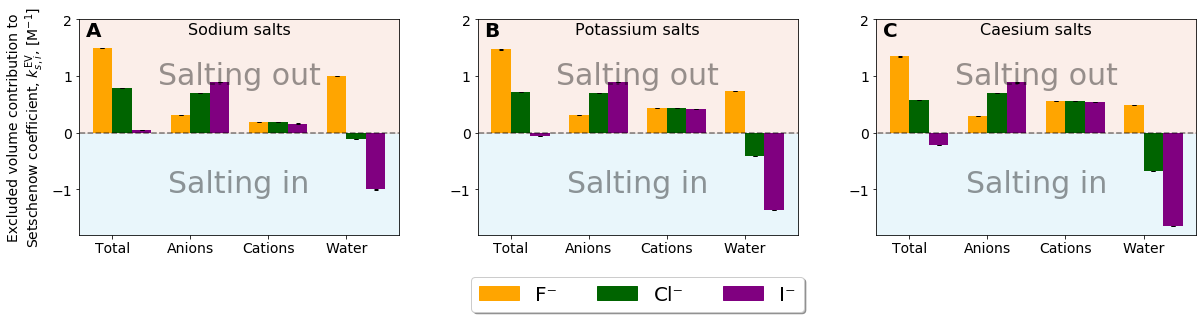

In [13]:
fig, axes = plt.subplots(1,3, sharex=True)
fig.set_size_inches(17,4.5)
colors = ['orange', 'darkgreen', 'purple']

# Histogram settings
width=0.25
index = np.arange(4)

counter = 0
offset = 0
for i,salt in enumerate(SetCof_eV):
    if i != 0 and i%3 == 0:
        counter +=1
        offset = 0
    
    axes[counter].bar(index+offset, salt, color=colors[i%3], label=i, width=width,
                      alpha=1.0, yerr=SetCofErr_eV[i],capsize=2)

    offset += width

for i,ax in enumerate(axes):
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(('Total', 'Anions', 'Cations', 'Water'), fontsize=14)
    ax.set_ylim(-1.8, 2.0)
    ax.set_xlim(-0.3, 3.8)
    ax.text(0.02, 0.92, string.ascii_uppercase[i], transform=axes[i].transAxes, 
                    size=20, weight='bold')
    ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed')
    ax.fill_between(np.arange(-5, 5, 0.1), [-5.2 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                    color='#c9e9f6', alpha=0.4)
    ax.fill_between(np.arange(-5, 5, 0.1), [4.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                    color='#f6d6c9', alpha=0.4)
    ax.text(1.75, -0.9, 'Salting in', horizontalalignment='center', verticalalignment='center',
            fontsize=30, alpha=0.4, zorder=10)
    ax.text(1.75, 1.0, 'Salting out', horizontalalignment='center', verticalalignment='center',
            fontsize=30, alpha=0.4, zorder=10)
    ax.tick_params(axis='y', labelsize=14)
    
labels = ['F⁻', 'Cl⁻', 'I⁻']
axes[0].set_ylabel('Excluded volume contribution to\nSetschenow coefficient, $k_{{s,i}}^{{\mathrm{{EV}}}}$, [M$^{{-1}}$]', fontsize=14)
axes[0].set_title('Sodium salts', pad=-15, y=1.001, fontsize=16)
axes[1].set_title('Potassium salts', pad=-15, y=1.001, fontsize=16)
axes[2].set_title('Caesium salts', pad=-15, y=1.001, fontsize=16)
handles = [mpatches.Patch(color='orange', label='F⁻'),
           mpatches.Patch(color='darkgreen', label='Cl⁻'),
           mpatches.Patch(color='purple', label='I⁻')]
axes[1].legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, shadow=True, ncol=5, fontsize='large', prop={'size': 20})
fig.tight_layout()
fig.savefig('images/SetschenowExcludedVolumeDecomposition.pdf', bbox_inches='tight')

## Solute-Solvent Interaction Contribution to the Setschenow Coefficient
Having in the previous looked at excluded volume contribution, which is associated with the high-energy regime of the energy of the energy-coordinate, we now turn to the remaining of the energy coordinate. The solvation free energy in this regime is given by
\begin{equation}
    \Delta G_i = \langle \nu \rangle_i - \int_{-\infty}^{\varepsilon_{\mathrm{max}}} f(\varepsilon_i) \ \mathrm{d}\varepsilon_i
\end{equation}
In the above equation we see the first term is the average pair energy between the solute and solvent, thus reflecting the solute-solvent interactions introduced in the system, while the second term is the functional term which is associated with solvent reorientation by introducing the solute going from $\lambda=0$ to $\lambda=1$. These two terms can be treated together or independently.
### Mean Interactions + Functional
In the following code we will now compute the Setschenow coefficient using the solute-solvent interaction component of the free energy of solvation for the chemical species. To obtain the error we ones more utilize non-parametric bootstrapping, being the slowest element of the code and may be varried to speed up the computation.

_<b>Warning</b>: Slow computation cell. Vary the input to the `BootstrapLinearRegression` function to decrease the computation time._

In [14]:
files = ['_results.yml', '_results_Ksalts.yml', '_results_Cssalts.yml'] # Sodium, Kalium, Caesium
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.00, 0.50, 1.00, 1.50, 2.00]

SetCof_Int     = np.empty(shape=(len(salts), 4))
SetCofErr_Int     = np.empty(shape=(len(salts), 4))

for convar, salt in enumerate(salts):
    mu = []
    mu_error = []
    
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                concentrations = data['conc']
                break
    
    for specie in range(1,5):
        chempots = np.zeros(shape=(25, 5))
        for i, conc in enumerate(concs):
            if conc == 0 and (specie == 2 or specie ==3):
                chempots[:,0] = np.zeros(shape=(25))
            elif conc == 0:
                for fileNr in range(1,26):
                    data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/Nosalt/cumsfe{fileNr:02d}'.format(fileNr=fileNr),
                                      usecols=(0,1))
                    chempots[fileNr-1,0] = np.interp(20, data[:,0], data[:,1])
            else:
                for fileNr in range(1,26):
                    data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/cumsfe{fileNr:02d}'.format(salt=salt, conc=conc, fileNr=fileNr),
                                      usecols=(0, specie))
                    chempots[fileNr-1,i] = np.interp(20, data[:,0], data[:,1])
                    
        popt = BootstrapLinearRegression(concentrations, chempots)
        mu.append(popt[0][0]*kcal_to_kT)
        mu_error.append(popt[0][1]*kcal_to_kT)

    SetCof_Int[convar] = np.array(mu); SetCofErr_Int[convar] = np.array(mu_error)

### Linear correlation between the interaction component Setschenow coefficient and Setschenow coefficient.

r² value: 0.8024954054324912
p-value:  0.0010837737989967348


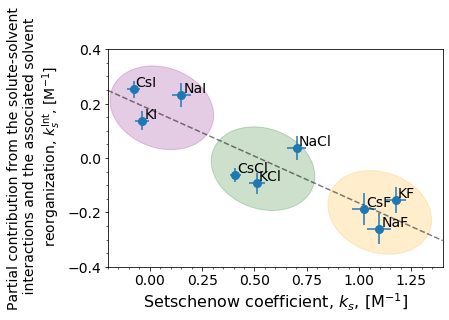

In [15]:
stats = linregress(SetCof[:,0], SetCof_Int[:,0])
print('r² value: {}'.format(stats.rvalue**2))
print('p-value:  {}'.format(stats.pvalue))
        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.errorbar(SetCof[:,0], SetCof_Int[:,0], yerr=SetCofErr_Int[:,0], xerr=SetCofErr[:,0], marker='o', linestyle='None', markersize=8)
for i, txt in enumerate(salts):
    ax.annotate(txt, (SetCof[:,0][i]+0.01, SetCof_Int[:,0][i]+0.01), fontsize=14)
ax.plot(np.arange(-0.5, 1.5, 0.001), np.arange(-0.5, 1.5, 0.001)*stats.slope + stats.intercept,
        alpha=0.5, color='black', linestyle='dashed')

for anion in range(3): # loop over anion species
    x = SetCof[:,0][anion:-1:3].mean()
    y = SetCof_Int[:,0][anion:-1:3].mean()
    el = mpatches.Ellipse((x, y), 0.3, 0.5, angle=-100, alpha=0.2, color=colors[anion])
    ax.add_artist(el)

ax.minorticks_on()
ax.set_xlim(-0.2, 1.4)
ax.set_ylim(-0.4, 0.4)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel(f'Partial contribution from the solute-solvent\n interactions and the associated solvent\n reorganization, $k_{{s}}^{{\mathrm{{Int}}}}$, [M$^{{-1}}$]', fontsize=14)
ax.set_xlabel(r'Setschenow coefficient, $k_s$, [M$^{-1}$]', fontsize=16)
fig.savefig('images/InteractionCorrelation.pdf', bbox_inches='tight')

### Correlation species decompositon

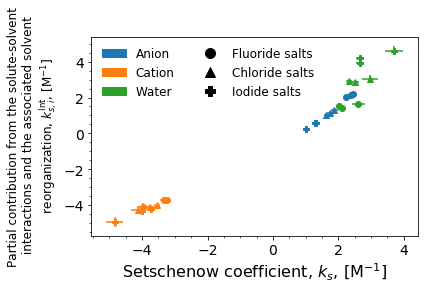

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

colors = ['C0', 'C1', 'C2']
labels = ['Anion', 'Cation', 'Water']
markers = ['o', '^', 'P']
for specie in range(1,4):
    for salt in range(len(salts)):
        color  = colors[specie-1]
        marker = markers[salt%3]
        ax.errorbar(SetCof[salt,specie], SetCof_Int[salt,specie], xerr=SetCofErr[salt,specie], yerr=SetCofErr_Int[salt,specie],
                    color=color, marker=marker, linestyle='None')

handles = [mpatches.Patch(color='C0', label='Anion'), mpatches.Patch(color='C1', label='Cation'),
           mpatches.Patch(color='C2', label='Water'),
           mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Fluoride salts'),
           mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='Chloride salts'),
           mlines.Line2D([], [], color='black', marker='P', linestyle='None', markersize=10, label='Iodide salts')]
ax.legend(loc=2, handles=handles, frameon=False, ncol=2, prop={'size': 12})

# Beautification
ax.minorticks_on()
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel(f'Partial contribution from the solute-solvent\n interactions and the associated solvent\n reorganization, $k_{{s,i}}^{{\mathrm{{Int}}}}$, [M$^{{-1}}$]', fontsize=12)
ax.set_xlabel(r'Setschenow coefficient, $k_s$, [M$^{-1}$]', fontsize=16)
fig.tight_layout()

### Species decomposition of the interaction component Setschenow coefficient

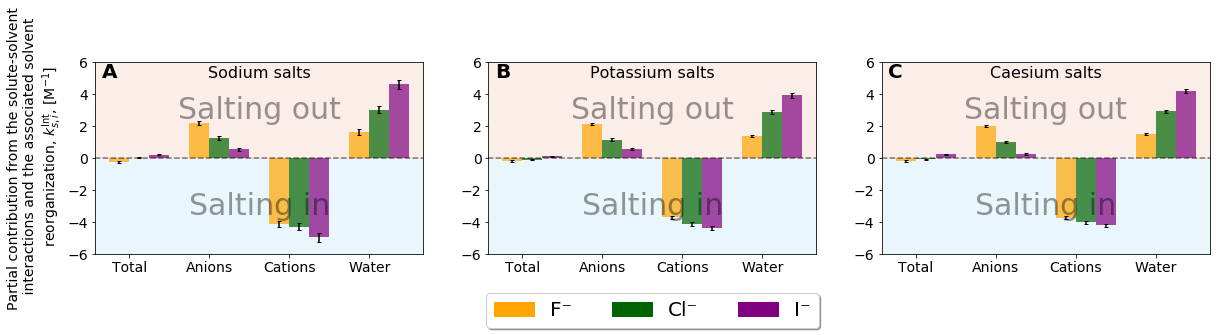

In [17]:
fig, axes = plt.subplots(1,3, sharex=True)
fig.set_size_inches(17,4.5)
colors = ['orange', 'darkgreen', 'purple']

# Histogram settings
width=0.25
index = np.arange(4)

counter = 0
offset = 0
for i,salt in enumerate(SetCof_Int):
    if i != 0 and i%3 == 0:
        counter +=1
        offset = 0
    
    axes[counter].bar(index+offset, salt, yerr=SetCofErr_Int[i] ,color=colors[i%3],
                      label=i, width=width, alpha=0.7, capsize=2)

    offset += width

for i,ax in enumerate(axes):
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(('Total', 'Anions', 'Cations', 'Water'), fontsize=14)
    ax.set_ylim(-6, 6)
    ax.set_xlim(-0.3, 3.8)
    ax.text(0.02, 0.92, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
    ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed')
    ax.fill_between(np.arange(-5, 5, 0.1), [-6.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                    color='#c9e9f6', alpha=0.4)
    ax.fill_between(np.arange(-5, 5, 0.1), [6.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                    color='#f6d6c9', alpha=0.4)
    ax.text(1.75, -3.0, 'Salting in', horizontalalignment='center', verticalalignment='center',
            fontsize=30, alpha=0.4, zorder=10)
    ax.text(1.75, 3.0, 'Salting out', horizontalalignment='center', verticalalignment='center',
            fontsize=30, alpha=0.4, zorder=10)
    ax.tick_params(axis='y', labelsize=14)
    
labels = ['F⁻', 'Cl⁻', 'I⁻']
axes[0].set_ylabel('Partial contribution from the solute-solvent\n interactions and the associated solvent\n reorganization, $k_{{s,i}}^{{\mathrm{Int}}}}$, [M$^{{-1}}$]', fontsize=14)
axes[0].set_title('Sodium salts', pad=-15, y=1.001, fontsize=16)
axes[1].set_title('Potassium salts', pad=-15, y=1.001, fontsize=16)
axes[2].set_title('Caesium salts', pad=-15, y=1.001, fontsize=16)
handles = [mpatches.Patch(color='orange', label='F⁻'),
           mpatches.Patch(color='darkgreen', label='Cl⁻'),
           mpatches.Patch(color='purple', label='I⁻')]
axes[1].legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=5, fontsize='large', prop={'size': 20})
fig.tight_layout()
fig.savefig('images/SetschenowInteractionDecomposition.pdf', bbox_inches='tight')

### Mean interaction only
In the previous we looked at how the contribution from the mean solute-solvent interactions and the functional varried with different salts and concentrations. In the following we will now mean solute-solvent interaction term exclusively.
### Species decomposition of the mean solute-solvent interaction variation with salt conentration

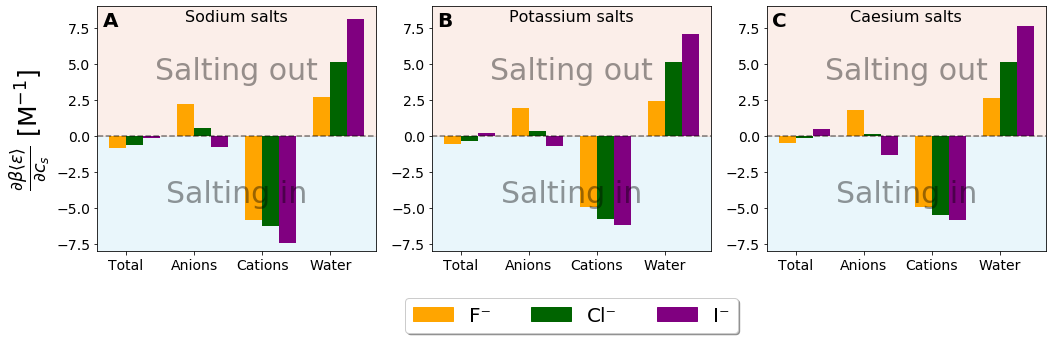

In [21]:
files = ['_results.yml', '_results_Ksalts.yml', '_results_Cssalts.yml'] # Sodium, Kalium, Caesium
salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.50, 1.00, 1.50, 2.00]

SetCof_Int = np.empty(shape=(len(salts), 4))

for i, salt in enumerate(salts):
    avgInt = np.zeros(shape=(len(concs)+1, 3))
    avgInt[0,2] = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/Nosalt/soln/aveuv.tt', usecols=(1)).mean()
    for j, conc in enumerate(concs):
        data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/soln/aveuv.tt'.format(salt=salt,conc=conc),
                          usecols=(1,2,3))
        avgInt[j+1,:] = data.mean(axis=0)
    
    avgInt = np.insert(avgInt, 0, avgInt.sum(axis=1), axis=1)
    
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                concentrations = data['conc']
                break
    
    for specie in range(4):
        stats = linregress(concentrations, avgInt[:,specie])
        if specie > 1: # Total and anion contribution does not behave linearly sadly.
            assert stats.rvalue**2 >= 0.95, "r**2 value is less than 0.95 for salt {} solvent id {}".format(salt,specie)
        SetCof_Int[i, specie] = stats.slope * kcal_to_kT
        
        
fig, axes = plt.subplots(1,3, sharex=True)
fig.set_size_inches(17,4.5)
colors = ['orange', 'darkgreen', 'purple']

# Histogram settings
width=0.25
index = np.arange(4)

counter = 0
offset = 0
for i,salt in enumerate(SetCof_Int):
    if i != 0 and i%3 == 0:
        counter +=1
        offset = 0
    
    axes[counter].bar(index+offset, salt, color=colors[i%3], label=i, width=width, alpha=1.0, capsize=2)
    offset += width

for i,ax in enumerate(axes):
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(('Total','Anions', 'Cations', 'Water'), fontsize=14)
    ax.set_ylim(-8, 9.0)
    ax.set_xlim(-0.3, 3.8)
    ax.text(0.02, 0.92, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
    ax.hlines(0, -1, 4, color='black', alpha=0.5, linestyle='dashed')
    ax.fill_between(np.arange(-5, 5, 0.1), [-9.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                    color='#c9e9f6', alpha=0.4)
    ax.fill_between(np.arange(-5, 5, 0.1), [9.1 for i in range(len(np.arange(-5, 5, 0.1)))], y2=0,
                    color='#f6d6c9', alpha=0.4)
    ax.text(1.75, -4.0, 'Salting in', horizontalalignment='center', verticalalignment='center',
            fontsize=30, alpha=0.4, zorder=10)
    ax.text(1.75, 4.5, 'Salting out', horizontalalignment='center', verticalalignment='center',
            fontsize=30, alpha=0.4, zorder=10)
    ax.tick_params(axis='y', labelsize=14)
    
    
    
labels = ['F⁻', 'Cl⁻', 'I⁻']
axes[0].set_ylabel(r'$\frac{\partial \beta \langle \varepsilon \rangle}{\partial c_s}$ [M$^{{-1}}$]', fontsize=25)
axes[0].set_title('Sodium salts', pad=-15, y=1.001, fontsize=16)
axes[1].set_title('Potassium salts', pad=-15, y=1.001, fontsize=16)
axes[2].set_title('Caesium salts', pad=-15, y=1.001, fontsize=16)
handles = [mpatches.Patch(color='orange', label='F⁻'),
           mpatches.Patch(color='darkgreen', label='Cl⁻'),
           mpatches.Patch(color='purple', label='I⁻')]
axes[1].legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=5, fontsize='large', prop={'size': 20})
fig.savefig('images/SetschenowMeanInteractionDecomposition.pdf', bbox_inches='tight')

### Linear correlation between the mean pair interaction energy variation with salt and the Setschenow coefficient.

r² value: 0.8337116649917345
p-value:  0.0005850660909841931


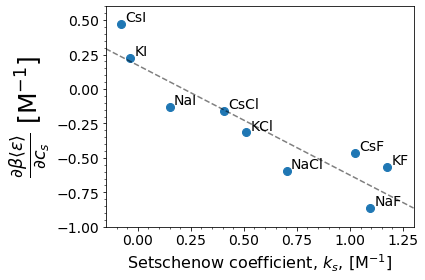

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

salts = ['NaF', 'NaCl', 'NaI', 'KF', 'KCl', 'KI', 'CsF', 'CsCl', 'CsI']
concs = [0.50, 1.00, 1.50, 2.00]

SetCof_Int = np.empty(shape=(len(salts)))

avgInt = np.zeros(shape=(len(concs)+1))
avgInt[0] = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/Nosalt/soln/aveuv.tt', usecols=(1)).mean()

for i, salt in enumerate(salts):
    for j, conc in enumerate(concs):
        data = np.loadtxt('/home/stefan/Caffeine_solubility/Simulations/{salt}/{conc:.2f}/soln/aveuv.tt'.format(salt=salt,conc=conc),
                          usecols=(1,2,3))
        avgInt[j+1] = data.mean(axis=0).sum(axis=0)
        
    for file in files: # Loop over cations
        with open('Simulations/{}'.format(file)) as f: # open structured result file (YAML)
            r = yaml.load(f, Loader=yaml.Loader)
        for data in r['salts']:
            if (data['label'] == salt):
                concentrations = data['conc']
                break
    
    stats = linregress(concentrations, avgInt)
    SetCof_Int[i] = stats.slope * kcal_to_kT

    

ax.plot(SetCof[:,0], SetCof_Int, marker='o', linestyle='none', markersize=8)
for i, txt in enumerate(salts):
    ax.annotate(txt, (SetCof[:,0][i]+0.02, SetCof_Int[i]+0.02), fontsize=14)
    
stats = linregress(SetCof[:,0], SetCof_Int)
print('r² value: {}'.format(stats.rvalue**2))
print('p-value:  {}'.format(stats.pvalue))
        

ax.plot(np.arange(-0.5, 1.5, 0.001), np.arange(-0.5, 1.5, 0.001)*stats.slope + stats.intercept,
        alpha=0.5, color='black', linestyle='dashed')
    
# Beautification
ax.set_xlim(-0.15, 1.3)
ax.set_ylim(-1, 0.6)
ax.tick_params(axis='both', labelsize=14)
ax.minorticks_on()
ax.set_ylabel(r'$\frac{\partial \beta \langle \varepsilon \rangle}{\partial c_s}$ [M$^{{-1}}$]', fontsize=25)
ax.set_xlabel(r'Setschenow coefficient, $k_s$, [M$^{-1}$]', fontsize=16)
fig.tight_layout()
fig.savefig('images/SetschenowMeanInteractionCorrelation.pdf', bbox_inches='tight')

## Thermodynamics of Liquid structure and Decomposition by Caffeine Motifs
In the following we will analyze the solution ($\lambda=1$) trajectories for structual properties which can be linked to the knowledge obtainable using energy-representation theory of solvation. In the following we will in particular look at the radial distrubtion functions, $g(r)$, between caffeine and solvent species.

In [23]:
salts = {'NaF'  : {'Cation': 'Na', 'Anion': 'F'  },
         'NaCl' : {'Cation': 'Na', 'Anion': 'Cl',},
         'NaI'  : {'Cation': 'Na', 'Anion': 'I'  },
         'KF'   : {'Cation': 'K' , 'Anion': 'F'  },
         'KCl'  : {'Cation': 'K' , 'Anion': 'Cl' },
         'KI'   : {'Cation': 'K' , 'Anion': 'I'  },
         'CsF'  : {'Cation': 'Cs', 'Anion': 'F'  },
         'CsCl' : {'Cation': 'Cs', 'Anion': 'Cl' },
         'CsI'  : {'Cation': 'Cs', 'Anion': 'I'  }
        }
# Anion and Cation residue names
resnames = {'Na': 'SOD',
            'K' : 'K',
            'Cs': 'CES',
            'Cl': 'CLA',
            'I' : 'IOD',
            'F' : 'FLO'
           }

parameters = {
    'Na' : {'Sigma': 0.2586, 'Epsilon': 0.4184},
    'K'  : {'Sigma': 0.3334, 'Epsilon': 0.4184},
    'Cs' : {'Sigma': 0.38,   'Epsilon': 0.42  },
    'Cl' : {'Sigma': 0.4401, 'Epsilon': 0.4184},
    'I'  : {'Sigma': 0.5149, 'Epsilon': 0.4184},
    'F'  : {'Sigma': 0.3143, 'Epsilon': 0.6999},
}

### Radial distrubtion function between caffeine and the cations.
Precomputed rdf files in the folder `data`.

_<b>Warning</b>: Slow computation and high memory requiring cell if calculating rdfs based on trajectory files._

NaF
NaCl
NaCl
NaI
KCl
CsCl


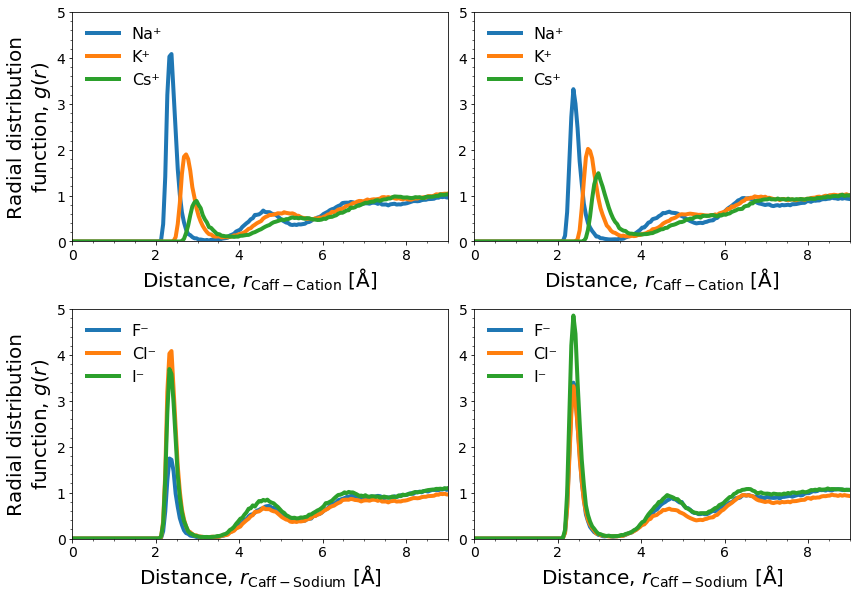

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4*2.1))

for salt in salts.values():
    if salt['Cation']+salt['Anion'] in ['NaCl', 'KCl', 'CsCl']:
        print(salt['Cation']+salt['Anion'])
     
        traj, rdf, pairs = None, None, None
        traj = md.load_xtc('Simulations/{salt}/1.00/trajectory_sol_full.xtc'.format(salt=str(salt['Cation']+salt['Anion'])),
                           top='Simulations/{salt}/1.00/1/Caffeine_{salt}_sol_1.pdb'.format(salt=str(salt['Cation']+salt['Anion'])))
        
        for i, ketoneGroup in enumerate(['15', '21']):
            pairs = traj.topology.select_pairs(selection1="index {}".format(ketoneGroup),
                                               selection2="resname {}".format(resnames[salt['Cation']]))
            rdf = md.compute_rdf(traj, pairs)
            axes[0][i].plot(rdf[0]*10, rdf[1], label=salt['Cation']+'⁺', linewidth=4)
    
    if salt['Cation']+salt['Anion'] in ['NaF', 'NaCl', 'NaI']:
        print(salt['Cation']+salt['Anion'])
     
        traj, rdf, pairs = None, None, None
        traj = md.load_xtc('Simulations/{salt}/1.00/trajectory_sol_full.xtc'.format(salt=str(salt['Cation']+salt['Anion'])),
                           top='Simulations/{salt}/1.00/1/Caffeine_{salt}_sol_1.pdb'.format(salt=str(salt['Cation']+salt['Anion'])))
        
        for i, ketoneGroup in enumerate(['15', '21']):
            pairs = traj.topology.select_pairs(selection1="index {}".format(ketoneGroup),
                                               selection2="resname {}".format(resnames[salt['Cation']]))
            rdf = md.compute_rdf(traj, pairs)
            axes[1][i].plot(rdf[0]*10, rdf[1], label=salt['Anion']+'⁻', linewidth=4)

for i,ax in enumerate(axes.flat):
    if i <= 1:
        ax.set_xlabel(r'Distance, $r_{\mathrm{Caff-Cation}}$ [Å]', fontsize=20)
    elif i > 1:
        ax.set_xlabel(r'Distance, $r_{\mathrm{Caff-Sodium}}$ [Å]', fontsize=20)
    ax.minorticks_on()
    ax.legend(loc=2, frameon=False, prop={'size': 16})
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 5)
    ax.tick_params(axis='both', labelsize=14)
    
axes[0][0].set_ylabel('Radial distribution\nfunction, $g(r)$', fontsize=20)
axes[1][0].set_ylabel('Radial distribution\nfunction, $g(r)$', fontsize=20)
#axes[0][0].set_title('Ketone group 1')
#axes[0][1].set_title('Ketone group 2')

fig.tight_layout()
fig.savefig('images/KetoneRDF.pdf', bbox_inches='tight')

### Radial distrubtion function between caffeine and the anions.
Precomputed rdf files in the folder `data`.

_<b>Warning</b>: Slow computation and high memory requiring cell if calculating rdfs based on trajectory files._

NaF
NaCl
NaI
NaI already loaded
KI
CsI


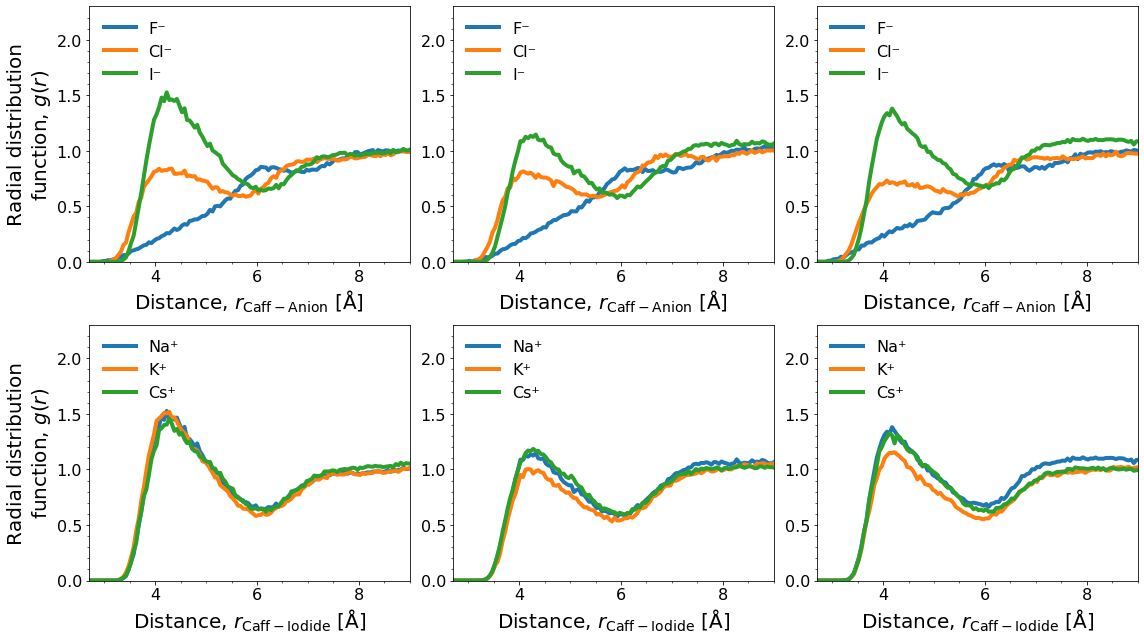

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))

for salt in salts.values():
    if salt['Cation']+salt['Anion'] in ['NaF', 'NaCl', 'NaI']:
        print(salt['Cation']+salt['Anion'])
     
        traj, rdf, pairs = None, None, None
        traj = md.load_xtc('Simulations/{salt}/1.00/trajectory_sol_full.xtc'.format(salt=str(salt['Cation']+salt['Anion'])),
                           top='Simulations/{salt}/1.00/1/Caffeine_{salt}_sol_1.pdb'.format(salt=str(salt['Cation']+salt['Anion'])))
        
        for i, methylGroup in enumerate(['0', '16', '22']):
            pairs = traj.topology.select_pairs(selection1="index {}".format(methylGroup),
                                               selection2="resname {}".format(resnames[salt['Anion']]))
            rdf = md.compute_rdf(traj, pairs)
            axes[0][i].plot(rdf[0]*10, rdf[1], label=salt['Anion']+'⁻', linewidth=4)
        CurrentlyLoaded = salt['Cation']+salt['Anion']
    
        
    if salt['Cation']+salt['Anion'] in ['NaI', 'KI', 'CsI']:        
        if salt['Cation']+salt['Anion'] != CurrentlyLoaded:
            print(salt['Cation']+salt['Anion'])
            traj, rdf, pairs = None, None, None
            traj = md.load_xtc('Simulations/{salt}/1.00/trajectory_sol_full.xtc'.format(salt=str(salt['Cation']+salt['Anion'])),
                               top='Simulations/{salt}/1.00/1/Caffeine_{salt}_sol_1.pdb'.format(salt=str(salt['Cation']+salt['Anion'])))
        else:
            print(salt['Cation']+salt['Anion']+' already loaded')
        
        for i, methylGroup in enumerate(['0', '16', '22']):
            pairs = traj.topology.select_pairs(selection1="index {}".format(methylGroup),
                                               selection2="resname {}".format(resnames[salt['Anion']]))
            rdf = md.compute_rdf(traj, pairs)
            axes[1][i].plot(rdf[0]*10, rdf[1], label=salt['Cation']+'⁺', linewidth=4)

for i,ax in enumerate(axes.flat):
    if i <= 2:
        ax.set_xlabel(r'Distance, $r_{\mathrm{Caff-Anion}}$ [Å]', fontsize=20)
    elif i > 2:
        ax.set_xlabel(r'Distance, $r_{\mathrm{Caff-Iodide}}$ [Å]', fontsize=20)
    ax.minorticks_on()
    ax.legend(loc=2, frameon=False, prop={'size': 16})
    ax.set_xlim(2.7, 9)
    ax.set_ylim(0, 2.3)
    ax.tick_params(axis='both', labelsize=16)
    
axes[0][0].set_ylabel('Radial distribution\nfunction, $g(r)$', fontsize=20)
axes[1][0].set_ylabel('Radial distribution\nfunction, $g(r)$', fontsize=20)
fig.tight_layout()
fig.savefig('images/MethylRDF.pdf', bbox_inches='tight')

### Change in water density upon addition of salt
Visualization of the water number density, $N_{\mathrm{water}}/V$, as a function of the number of ion-pairs present in the system for the various salts studied. The densities are calculated in the absence of caffeine, i.e. at $\lambda=0$.

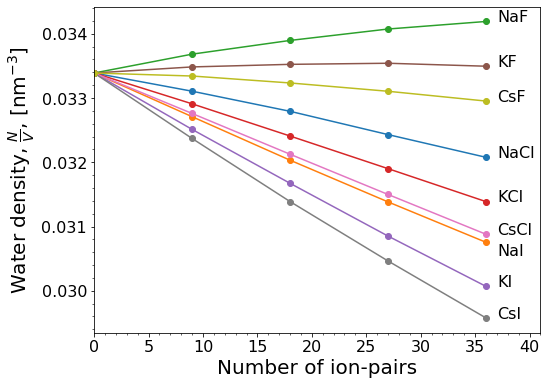

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Get zero salt:
%cd -q $homedir/Simulations/Nosalt
water_volume = getAvgVolume('output_ref.dat', returning='float')

Nions = [0, 9, 18, 27, 36]

for salt in salts:
    volume = [water_volume]
    for concentration in salt_concentrations:
        conc = '{0:.2f}'.format(concentration)
        %cd -q $homedir/Simulations/$salt/$conc
        volume.append(getAvgVolume('output_ref.dat', returning='float'))
    ax.plot(Nions, 1000/np.array(volume), marker='o')
    if salt == 'NaI':
        ax.text(Nions[-1]+1, 1000/volume[-1]-0.0002, s=salt, fontsize=16)
    else:
        ax.text(Nions[-1]+1, 1000/volume[-1], s=salt, fontsize=16)

%cd -q $homedir
ax.set_xlim(0, 41)
ax.minorticks_on()
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel(r'Number of ion-pairs', fontsize=20)
ax.set_ylabel(r'Water density, $\frac{N}{V}$, [nm$^{-3}$]', fontsize=20)
fig.savefig('images/WaterDensity.pdf', bbox_inches='tight')